# PINN Baseline on 1D Sine-Driven PDE

本节训练一个单隐藏层的 PINN，在 1D 正弦驱动 PDE（µ=4, right_by=0, activation="tanh"）上，
并绘制其训练 loss 曲线。对比 PIRBN （Notebook 1）和 PINN 的 final loss，
请手动查看 Notebook 1 的输出记录。


In [6]:
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
import matplotlib.pyplot as plt

# 准备数据：同 sine_function_main 用的
mu = 4
right_by = 0
ns = 50
dx = 1.0 / (ns - 1)
x_eq = np.linspace(0.0, 1.0, ns)[:, None].astype("float32")
for i in range(ns):
    x_eq[i, 0] = i * dx + right_by
y_eq = -4 * mu**2 * np.pi**2 * np.sin(2 * mu * np.pi * x_eq).astype("float32")

# 转为 Paddle Tensor
x_t = paddle.to_tensor(x_eq)
y_t = paddle.to_tensor(y_eq)


In [7]:
# 定义 PINN：1 隐藏层 + tanh
class PINNNet(nn.Layer):
    def __init__(self, n_hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(1, n_hidden)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, 1)
    def forward(self, x):
        h = self.act(self.fc1(x))
        return self.fc2(h)

pinn = PINNNet(n_hidden=32)
optimizer = optim.Adam(parameters=pinn.parameters(), learning_rate=1e-3)
mse = nn.MSELoss()


In [12]:
# 训练 PINN 并记录 loss
pinn_losses = []
for it in range(20001):
    pred = pinn(x_t)
    loss = mse(pred, y_t)
    loss.backward()
    optimizer.step()
    optimizer.clear_grad()
    pinn_losses.append(loss.numpy().item())

    if it % 5000 == 0:
        print(f"Iter {it:5d}  loss {loss.numpy().item():.6f}")
print("PINN final loss:", pinn_losses[-1])


Iter     0  loss 195494.875000
Iter  5000  loss 186948.156250
Iter 10000  loss 176644.781250
Iter 15000  loss 169979.656250
Iter 20000  loss 166147.265625
PINN final loss: 166147.265625


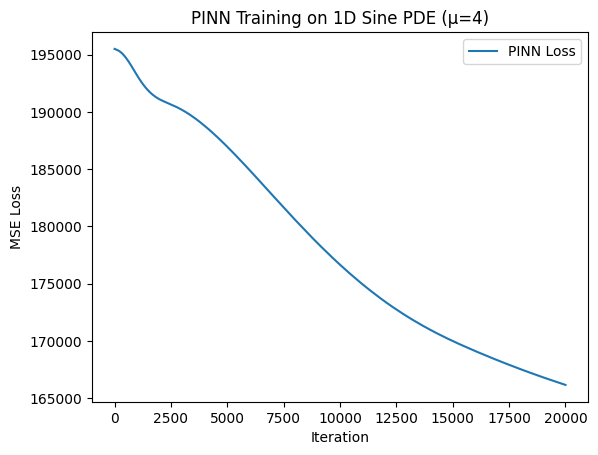

In [13]:
# 绘制 PINN loss 曲线
plt.plot(pinn_losses, label="PINN Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("PINN Training on 1D Sine PDE (µ=4)")
plt.legend()
plt.show()
